In [53]:
# --- STAGE 1: Data Loading and Initial Preparation ---

import pandas as pd
import numpy as np

print("--- STAGE 1 START ---")

# --- 1a. Load CSV files ---
try:
    # Adjust paths if your 'data' folder is located differently
    data_path = '../data/f1_world_champion/' # Assuming data CSVs are in the same directory as notebook
    # If in a subfolder 'data', use: data_path = 'data/'
    # If in a parent folder 'data', use: data_path = '../data/f1_world_champion/' # Like your original path

    results = pd.read_csv(f'{data_path}results.csv')
    races = pd.read_csv(f'{data_path}races.csv')
    drivers = pd.read_csv(f'{data_path}drivers.csv')
    constructors = pd.read_csv(f'{data_path}constructors.csv')
    qualifying = pd.read_csv(f'{data_path}qualifying.csv')
    circuits = pd.read_csv(f'{data_path}circuits.csv')
    status = pd.read_csv(f'{data_path}status.csv')
    # Load constructor results here as it's needed for feature engineering later
    constructor_results = pd.read_csv(f'{data_path}constructor_results.csv')
    print("All CSV files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading CSV file: {e}. Please check the 'data_path'.")
    raise

# --- 1b. Initial Merges ---
print("Starting initial merges...")
# Select relevant columns from races
races_subset = races[['raceId', 'year', 'round', 'circuitId', 'date']]
# Start merging with results
df = pd.merge(results, races_subset, on='raceId', how='left')

# Merge driver info
drivers_subset = drivers[['driverId', 'driverRef', 'nationality', 'dob']]
df = pd.merge(df, drivers_subset, on='driverId', how='left')

# Merge constructor info
constructors_subset = constructors[['constructorId', 'name', 'nationality']]
constructors_subset = constructors_subset.rename(columns={'name': 'constructorName', 'nationality': 'constructorNationality'})
df = pd.merge(df, constructors_subset, on='constructorId', how='left')

# RENAME original 'grid' from results.csv FIRST to avoid conflicts
df = df.rename(columns={'grid': 'results_grid_start'})

# Merge qualifying position (ensure qualifying DataFrame is loaded)
if 'qualifying' in locals() and qualifying is not None:
    qualifying_subset = qualifying[['raceId', 'driverId', 'constructorId', 'position']]
    qualifying_subset = qualifying_subset.rename(columns={'position': 'grid'}) # This is the qualifying position
    df = pd.merge(df, qualifying_subset, on=['raceId', 'driverId', 'constructorId'], how='left')
    print("Merged qualifying info.")
else:
    print("Warning: Qualifying DataFrame not loaded. Grid position feature might be missing.")

# Merge circuit info
circuits_subset = circuits[['circuitId', 'name', 'location', 'country']]
circuits_subset = circuits_subset.rename(columns={'name': 'circuitName'})
df = pd.merge(df, circuits_subset, on='circuitId', how='left')

# Merge status info
status_subset = status[['statusId', 'status']]
df = pd.merge(df, status_subset, on='statusId', how='left')
print("Initial merges complete.")

# --- 1c. Data Cleaning and Filtering ---
print("Starting cleaning and filtering...")
# Find the statusId for 'Finished'
try:
    finished_status_id = status[status['status'] == 'Finished']['statusId'].iloc[0]
    print(f"Status ID for 'Finished' is: {finished_status_id}")
except IndexError:
    print("Warning: Could not find 'Finished' status in status.csv.")
    finished_status_id = None

# Filter for drivers who finished the race
if finished_status_id is not None:
    df_cleaned = df[df['statusId'] == finished_status_id].copy()
    print(f"Filtered for finished drivers. Shape: {df_cleaned.shape}")
else:
    print("Skipping filtering by 'Finished' status.")
    df_cleaned = df.copy()

# Basic Type Conversions / Cleaning
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'], errors='coerce')
df_cleaned['dob'] = pd.to_datetime(df_cleaned['dob'], errors='coerce')

# Handle missing grid positions (fill with 0 for simplicity)
if 'grid' in df_cleaned.columns:
     df_cleaned['grid'] = pd.to_numeric(df_cleaned['grid'], errors='coerce')
     df_cleaned['grid'] = df_cleaned['grid'].fillna(0)
     print("Filled NaN grid positions with 0.")
else:
     print("Warning: 'grid' column not found after merging qualifying info.")

# --- 1d. Define RAW Target Variables ---
# Create targets on this intermediate DataFrame before feature engineering
if 'positionOrder' in df_cleaned.columns:
    df_cleaned['target_finishing_position'] = df_cleaned['positionOrder']
    df_cleaned['target_podium_finish'] = df_cleaned['positionOrder'].apply(lambda x: 1 if x <= 3 else 0)
    print("Created base target variables.")
else:
    print("Warning: 'positionOrder' column not found. Cannot create target variables.")


# --- Sort DataFrame Chronologically (IMPORTANT for historical features) ---
df_cleaned = df_cleaned.sort_values(by=['date', 'raceId']).reset_index(drop=True)
print("DataFrame sorted by date.")

print(f"--- STAGE 1 COMPLETE --- Shape: {df_cleaned.shape} ---")

--- STAGE 1 START ---
All CSV files loaded successfully.
Starting initial merges...
Merged qualifying info.
Initial merges complete.
Starting cleaning and filtering...
Status ID for 'Finished' is: 1
Filtered for finished drivers. Shape: (7674, 32)
Filled NaN grid positions with 0.
Created base target variables.
DataFrame sorted by date.
--- STAGE 1 COMPLETE --- Shape: (7674, 34) ---


In [54]:
# --- STAGE 3: Define Features, Targets, Split Data, Define Preprocessor ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Keep necessary imports for this block
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

print("--- STAGE 3 START ---")
# Make sure df_featured exists from Block 2
if 'df_featured' not in locals() or df_featured is None:
     raise NameError("DataFrame 'df_featured' not found. Please run Block 1 and 2 first.")

# --- 3a. Define Features and Targets ---
# Define the list of features we WANT to use if they were created successfully
# Using the list for the current test (Full features MINUS lap/pit/sprint)
categorical_features = [
    'driverId',
    'constructorId',
    'circuitId',
]
numerical_features = [
    'grid',
    'year',
    'avg_finish_pos_last_5',
    'avg_points_last_5',
    'avg_finish_at_circuit',
    'quali_diff_from_pole_ms',
    'teammate_grid_diff',
    'std_finish_pos_last_5', 
    'teammate_quali_time_diff_ms'
]

target_regr = 'target_finishing_position'
target_clas = 'target_podium_finish'

# --- Check Targets ---
missing_targets = [col for col in [target_regr, target_clas] if col not in df_featured.columns]
if missing_targets:
     raise ValueError(f"Missing required target columns in df_featured: {missing_targets}.")

# --- Robust Feature Selection ---
# Select ONLY the features from the desired lists that ACTUALLY EXIST in df_featured
features_to_use = [col for col in numerical_features_desired + categorical_features_desired if col in df_featured.columns]
print(f"Features available and selected from df_featured: {features_to_use}")

# Raise error only if essential base features are missing (optional, but good practice)
essential_features = ['grid', 'year', 'driverId', 'constructorId', 'circuitId']
missing_essential = [col for col in essential_features if col not in features_to_use]
if missing_essential:
    raise ValueError(f"Missing essential features in df_featured: {missing_essential}. Check Block 1/2.")


X = df_featured[features_to_use].copy() # Select only available desired features
y_regr = df_featured[target_regr]
y_clas = df_featured[target_clas]


# Handle potential NaNs in the final selected X
if X.isnull().sum().sum() > 0:
    print(f"Warning: NaNs found in final feature set X BEFORE imputation: \n{X.isnull().sum()}")
    # Impute NaNs - using 0 for simplicity
    X = X.fillna(0)
    print("Filled NaNs in X with 0.")


# --- 3b. Data Splitting ---
X_train, X_test, y_train_regr, y_test_regr = train_test_split(
    X, y_regr, test_size=0.2, random_state=42, stratify=df_featured['year'] # Stratify by year if available
)
y_train_clas = y_clas.loc[X_train.index]
y_test_clas = y_clas.loc[X_test.index]
print(f"Data split complete. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")


# --- 3c. Define Preprocessor (Dynamically identifies columns in X_train) ---
# Identify numerical and categorical columns *actually present* in X_train
numerical_cols_final = X_train.select_dtypes(include=np.number).columns.tolist()
# Identify categorical columns based on the original desired list that are *also* in X_train
categorical_cols_final = [col for col in categorical_features_desired if col in X_train.columns]

print(f"Numerical columns for pipeline: {numerical_cols_final}")
print(f"Categorical columns for pipeline: {categorical_cols_final}")

# Define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_final),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_final)
    ],
    remainder='passthrough' # Ensure no columns are left unprocessed
)
print("Preprocessor defined.")

# --- REMOVED: Pipeline definitions, fitting, and evaluation ---

print("--- STAGE 3 COMPLETE ---")

--- STAGE 3 START ---
Features available and selected from df_featured: ['grid', 'year', 'avg_finish_pos_last_5', 'avg_points_last_5', 'avg_finish_at_circuit', 'quali_diff_from_pole_ms', 'teammate_grid_diff', 'std_finish_pos_last_5', 'teammate_quali_time_diff_ms', 'driverId', 'constructorId', 'circuitId']
Data split complete. Train Shape: (6139, 12), Test Shape: (1535, 12)
Numerical columns for pipeline: ['grid', 'year', 'avg_finish_pos_last_5', 'avg_points_last_5', 'avg_finish_at_circuit', 'quali_diff_from_pole_ms', 'teammate_grid_diff', 'std_finish_pos_last_5', 'teammate_quali_time_diff_ms', 'driverId', 'constructorId', 'circuitId']
Categorical columns for pipeline: ['driverId', 'constructorId', 'circuitId']
Preprocessor defined.
--- STAGE 3 COMPLETE ---


In [55]:
# --- STAGE 3: Define Features, Targets, Split Data, Define Preprocessor ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Keep necessary imports for this block
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

print("--- STAGE 3 START ---")
# Make sure df_featured exists from Block 2
if 'df_featured' not in locals() or df_featured is None:
     raise NameError("DataFrame 'df_featured' not found. Please run Block 1 and 2 first.")

# --- 3a. Define Features and Targets ---
# Define the list of features we WANT to use based on Block 2 calculations
categorical_features_desired = [
    'driverId',
    'constructorId',
    'circuitId',
    # Removed: 'participated_in_sprint'
]
numerical_features_desired = [
    'grid',
    'year',
    'avg_finish_pos_last_5',
    'avg_points_last_5',
    'avg_finish_at_circuit',
    'quali_diff_from_pole_ms',
    'teammate_grid_diff',
    'std_finish_pos_last_5',           # NEW
    'teammate_quali_time_diff_ms'  # NEW
    # Removed: dnf_rate, lap_time, stops, sprint features
]

target_regr = 'target_finishing_position'
target_clas = 'target_podium_finish'

# --- Check Targets ---
missing_targets = [col for col in [target_regr, target_clas] if col not in df_featured.columns]
if missing_targets:
     raise ValueError(f"Missing required target columns in df_featured: {missing_targets}.")

# --- Robust Feature Selection ---
features_to_use = [col for col in numerical_features_desired + categorical_features_desired if col in df_featured.columns]
print(f"Features available and selected from df_featured: {features_to_use}")

# Check if essential features were selected
essential_features = ['grid', 'year', 'driverId', 'constructorId', 'circuitId']
missing_essential = [col for col in essential_features if col not in features_to_use]
if missing_essential:
    raise ValueError(f"Missing essential features in selected list: {missing_essential}. Check Block 2 execution.")

X = df_featured[features_to_use].copy()
y_regr = df_featured[target_regr]
y_clas = df_featured[target_clas]


# Handle potential NaNs just in case (e.g., from target joins)
if X.isnull().sum().sum() > 0:
    print(f"Warning: NaNs found in final feature set X BEFORE imputation: \n{X.isnull().sum()}")
    X = X.fillna(0) # Simple imputation
    print("Filled NaNs in X with 0.")
if y_regr.isnull().any() or y_clas.isnull().any():
     print(f"Warning: NaNs found in target variables. Regression NaNs: {y_regr.isnull().sum()}, Classification NaNs: {y_clas.isnull().sum()}")
     # Drop rows with NaN targets - essential for training
     nan_target_indices = X.index[y_regr.isnull() | y_clas.isnull()]
     X = X.drop(index=nan_target_indices)
     y_regr = y_regr.drop(index=nan_target_indices)
     y_clas = y_clas.drop(index=nan_target_indices)
     print(f"Dropped {len(nan_target_indices)} rows due to NaN targets.")


# --- 3b. Data Splitting ---
X_train, X_test, y_train_regr, y_test_regr = train_test_split(
    X, y_regr, test_size=0.2, random_state=42, stratify=df_featured.loc[X.index, 'year'] # Stratify using index from X
)
y_train_clas = y_clas.loc[X_train.index]
y_test_clas = y_clas.loc[X_test.index]
print(f"Data split complete. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")


# --- 3c. Define Preprocessor ---
numerical_cols_final = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols_final = [col for col in categorical_features_desired if col in X_train.columns]

print(f"Numerical columns for pipeline: {numerical_cols_final}")
print(f"Categorical columns for pipeline: {categorical_cols_final}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_final),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_final)
    ],
    remainder='passthrough'
)
print("Preprocessor defined.")

print("--- STAGE 3 COMPLETE ---")

--- STAGE 3 START ---
Features available and selected from df_featured: ['grid', 'year', 'avg_finish_pos_last_5', 'avg_points_last_5', 'avg_finish_at_circuit', 'quali_diff_from_pole_ms', 'teammate_grid_diff', 'std_finish_pos_last_5', 'teammate_quali_time_diff_ms', 'driverId', 'constructorId', 'circuitId']
Data split complete. Train Shape: (6139, 12), Test Shape: (1535, 12)
Numerical columns for pipeline: ['grid', 'year', 'avg_finish_pos_last_5', 'avg_points_last_5', 'avg_finish_at_circuit', 'quali_diff_from_pole_ms', 'teammate_grid_diff', 'std_finish_pos_last_5', 'teammate_quali_time_diff_ms', 'driverId', 'constructorId', 'circuitId']
Categorical columns for pipeline: ['driverId', 'constructorId', 'circuitId']
Preprocessor defined.
--- STAGE 3 COMPLETE ---


In [56]:
# --- STAGE 4: Hyperparameter Tuning with Optuna ---

import optuna
import numpy as np
import xgboost as xgb # Import XGBoost
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # Keep RF if you want to compare later
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
# Make sure necessary variables from Block 3 are available:
# preprocessor, X_train, y_train_regr, y_train_clas

print("--- STAGE 4 START ---")

N_TRIALS = 150 # Number of Optuna trials (increase for better search, e.g., 50-100)
CV_FOLDS = 5 # Number of cross-validation folds

# --- (Optional) Keep Original RF Tuning ---
# You can keep or comment out the RF tuning if you want
# print("\n--- Running Random Forest Tuning (as reference) ---")
# ... (Objective functions and studies for RF from previous Block 4 can remain here if desired) ...
# best_params_regr = study_regr.best_params # Store RF results if kept
# best_params_clas = study_clas.best_params # Store RF results if kept


# --- 4e. Objective Function for XGBoost Regression ---
def objective_regr_xgb(trial):
    # Suggest hyperparameters for XGBoost Regressor
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0), # Fraction of samples used per tree
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0), # Fraction of features used per tree
        'gamma': trial.suggest_float('gamma', 0, 5), # Minimum loss reduction required to make a further partition
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True), # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True), # L2 regularization
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRegressor(**param)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    score = cross_val_score(pipeline, X_train, y_train_regr, cv=CV_FOLDS, scoring='neg_mean_absolute_error', n_jobs=-1)
    return score.mean()

# --- 4f. Run Optuna Study for XGBoost Regression ---
print(f"\n--- Running XGBoost Tuning for Regression ---")
print(f"Starting Optuna study for XGBoost Regression (MAE, {N_TRIALS} trials, {CV_FOLDS}-fold CV)...")
study_regr_xgb = optuna.create_study(direction='maximize') # Maximize neg_mean_absolute_error
study_regr_xgb.optimize(objective_regr_xgb, n_trials=N_TRIALS)

print("Optuna study for XGBoost Regression complete.")
print("Best parameters (XGBoost Regression): ", study_regr_xgb.best_params)
print("Best value (Neg MAE): ", study_regr_xgb.best_value)
best_params_regr_xgb = study_regr_xgb.best_params


# --- 4g. Objective Function for XGBoost Classification ---
# Calculate scale_pos_weight (needs y_train_clas)
neg_count = np.sum(y_train_clas == 0)
pos_count = np.sum(y_train_clas == 1)
scale_pos_weight_val = neg_count / pos_count if pos_count > 0 else 1
print(f"\nCalculated scale_pos_weight for XGBClassifier Tuning: {scale_pos_weight_val:.2f}")

def objective_clas_xgb(trial):
    # Suggest hyperparameters for XGBoost Classifier
    param = {
        'objective': 'binary:logistic',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'scale_pos_weight': scale_pos_weight_val, # Use pre-calculated value
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBClassifier(**param)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    score = cross_val_score(pipeline, X_train, y_train_clas, cv=CV_FOLDS, scoring='f1', n_jobs=-1) # Optimize F1
    return score.mean()

# --- 4h. Run Optuna Study for XGBoost Classification ---
print(f"\n--- Running XGBoost Tuning for Classification ---")
print(f"Starting Optuna study for XGBoost Classification (F1 Score, {N_TRIALS} trials, {CV_FOLDS}-fold CV)...")
study_clas_xgb = optuna.create_study(direction='maximize') # Maximize F1 score
study_clas_xgb.optimize(objective_clas_xgb, n_trials=N_TRIALS)

print("Optuna study for XGBoost Classification complete.")
print("Best parameters (XGBoost Classification): ", study_clas_xgb.best_params)
print("Best value (F1 Score): ", study_clas_xgb.best_value)
best_params_clas_xgb = study_clas_xgb.best_params


print("--- STAGE 4 COMPLETE ---")

[I 2025-04-13 19:17:26,625] A new study created in memory with name: no-name-c8574b21-586d-400a-9324-9c463b4a477e


--- STAGE 4 START ---

--- Running XGBoost Tuning for Regression ---
Starting Optuna study for XGBoost Regression (MAE, 150 trials, 5-fold CV)...


[I 2025-04-13 19:17:30,014] Trial 0 finished with value: -1.814595675468445 and parameters: {'n_estimators': 500, 'learning_rate': 0.2550543730429191, 'max_depth': 9, 'subsample': 0.9287908999277841, 'colsample_bytree': 0.5264673294543344, 'gamma': 1.240304161673812, 'reg_alpha': 0.004359908533200314, 'reg_lambda': 0.0556943571927946}. Best is trial 0 with value: -1.814595675468445.
[I 2025-04-13 19:17:32,382] Trial 1 finished with value: -1.7535590887069703 and parameters: {'n_estimators': 200, 'learning_rate': 0.12291911764016404, 'max_depth': 9, 'subsample': 0.957314518107637, 'colsample_bytree': 0.894696216108742, 'gamma': 1.3391948319188829, 'reg_alpha': 1.4105706443352301e-06, 'reg_lambda': 1.9746927760593302e-08}. Best is trial 1 with value: -1.7535590887069703.
[I 2025-04-13 19:17:35,326] Trial 2 finished with value: -1.9003372192382812 and parameters: {'n_estimators': 400, 'learning_rate': 0.28828452583691844, 'max_depth': 9, 'subsample': 0.7148984317627807, 'colsample_bytree'

Optuna study for XGBoost Regression complete.
Best parameters (XGBoost Regression):  {'n_estimators': 1000, 'learning_rate': 0.010644583554761876, 'max_depth': 6, 'subsample': 0.5599806462135409, 'colsample_bytree': 0.7494025014791749, 'gamma': 1.543008569137056, 'reg_alpha': 9.761480341123842e-07, 'reg_lambda': 0.5175553679938097}
Best value (Neg MAE):  -1.6846101522445678

Calculated scale_pos_weight for XGBClassifier Tuning: 1.38

--- Running XGBoost Tuning for Classification ---
Starting Optuna study for XGBoost Classification (F1 Score, 150 trials, 5-fold CV)...


[I 2025-04-13 19:26:49,674] Trial 0 finished with value: 0.7615081380149882 and parameters: {'n_estimators': 400, 'learning_rate': 0.016160747220719307, 'max_depth': 3, 'subsample': 0.5057627005552591, 'colsample_bytree': 0.6735495115488385, 'gamma': 4.313843993741389, 'reg_alpha': 5.7227384940570204e-08, 'reg_lambda': 3.18647406630556e-08}. Best is trial 0 with value: 0.7615081380149882.
[I 2025-04-13 19:26:50,836] Trial 1 finished with value: 0.7598078957235049 and parameters: {'n_estimators': 200, 'learning_rate': 0.034186203954387616, 'max_depth': 6, 'subsample': 0.8744235867216301, 'colsample_bytree': 0.6526806501280292, 'gamma': 0.5510206761834635, 'reg_alpha': 3.4727696985487365e-08, 'reg_lambda': 2.3102295708326726e-06}. Best is trial 0 with value: 0.7615081380149882.
[I 2025-04-13 19:26:52,243] Trial 2 finished with value: 0.760004867582756 and parameters: {'n_estimators': 200, 'learning_rate': 0.025974542846877745, 'max_depth': 8, 'subsample': 0.7378038687678705, 'colsample_b

Optuna study for XGBoost Classification complete.
Best parameters (XGBoost Classification):  {'n_estimators': 700, 'learning_rate': 0.024238591207261816, 'max_depth': 4, 'subsample': 0.9376447701151667, 'colsample_bytree': 0.5651083477529208, 'gamma': 4.8161983664577255, 'reg_alpha': 0.1455042098716321, 'reg_lambda': 0.5547621208109449}
Best value (F1 Score):  0.7663053888101545
--- STAGE 4 COMPLETE ---


In [57]:
# --- STAGE 5: Final Model Training & Evaluation (Using Tuned XGBoost) ---

# --- Imports for this block ---
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report
# Import XGBoost models
import xgboost as xgb
# Make sure necessary variables are available from previous blocks:
# preprocessor, best_params_regr_xgb, best_params_clas_xgb, # Use the XGBoost params
# X_train, y_train_regr, y_train_clas, X_test, y_test_regr, y_test_clas

print("--- STAGE 5 START (Using Tuned XGBoost) ---")

# --- 5a. Define Final Pipelines with Tuned XGBoost Parameters ---
print("Defining final pipelines using best parameters found by Optuna for XGBoost...")

# Check if best parameters were found, otherwise use defaults as fallback
if 'best_params_regr_xgb' not in locals():
    print("Warning: Best XGBoost Regressor params not found, using defaults.")
    best_params_regr_xgb = {} # Empty dict results in defaults
if 'best_params_clas_xgb' not in locals():
    print("Warning: Best XGBoost Classifier params not found, using defaults.")
    best_params_clas_xgb = {} # Empty dict results in defaults


# Define XGBoost Regressor using parameters found by Optuna
final_xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    **best_params_regr_xgb, # Unpack the best parameters
    random_state=42,
    n_jobs=-1
)

# Define XGBoost Classifier using parameters found by Optuna
# Recalculate scale_pos_weight or ensure it's passed from Block 4 if needed
if 'scale_pos_weight_val' not in locals(): # Recalculate if not available
    neg_count = np.sum(y_train_clas == 0)
    pos_count = np.sum(y_train_clas == 1)
    scale_pos_weight_val = neg_count / pos_count if pos_count > 0 else 1
    print(f"Recalculated scale_pos_weight for final XGBClassifier: {scale_pos_weight_val:.2f}")

final_xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_val,
    **best_params_clas_xgb, # Unpack the best parameters
    random_state=42,
    n_jobs=-1
)

# Create full pipelines with TUNED XGBoost models
final_pipeline_regr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', final_xgb_regressor) # Use Tuned XGBoost Regressor
])

final_pipeline_clas = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', final_xgb_classifier) # Use Tuned XGBoost Classifier
])

# --- 5b. Train Final Models on FULL Training Data ---
print("Training final Tuned XGBoost Regression model on full training data...")
final_pipeline_regr.fit(X_train, y_train_regr)
print("Final Tuned XGBoost Regression model trained.")

print("Training final Tuned XGBoost Classification model on full training data...")
final_pipeline_clas.fit(X_train, y_train_clas)
print("Final Tuned XGBoost Classification model trained.")

# --- 5c. Evaluate Final Models on HELD-OUT Test Data ---
print("\n--- FINAL Tuned XGBoost Regression Model Evaluation (on Test Set) ---")
y_pred_regr_final = final_pipeline_regr.predict(X_test)
mae_final = mean_absolute_error(y_test_regr, y_pred_regr_final)
print(f"FINAL Mean Absolute Error (MAE) on Test Set: {mae_final:.4f}")

print("\n--- FINAL Tuned XGBoost Classification Model Evaluation (on Test Set) ---")
y_pred_clas_final = final_pipeline_clas.predict(X_test)
accuracy_final = accuracy_score(y_test_clas, y_pred_clas_final)
print(f"FINAL Accuracy on Test Set: {accuracy_final:.4f}")
print("\nFINAL Classification Report (on Test Set):")
print(classification_report(y_test_clas, y_pred_clas_final, target_names=['No Podium', 'Podium']))

print("--- STAGE 5 COMPLETE (Using Tuned XGBoost) ---")

--- STAGE 5 START (Using Tuned XGBoost) ---
Defining final pipelines using best parameters found by Optuna for XGBoost...
Training final Tuned XGBoost Regression model on full training data...
Final Tuned XGBoost Regression model trained.
Training final Tuned XGBoost Classification model on full training data...
Final Tuned XGBoost Classification model trained.

--- FINAL Tuned XGBoost Regression Model Evaluation (on Test Set) ---
FINAL Mean Absolute Error (MAE) on Test Set: 1.6833

--- FINAL Tuned XGBoost Classification Model Evaluation (on Test Set) ---
FINAL Accuracy on Test Set: 0.7805

FINAL Classification Report (on Test Set):
              precision    recall  f1-score   support

   No Podium       0.86      0.74      0.79       881
      Podium       0.70      0.84      0.77       654

    accuracy                           0.78      1535
   macro avg       0.78      0.79      0.78      1535
weighted avg       0.79      0.78      0.78      1535

--- STAGE 5 COMPLETE (Using Tune

--- STAGE 6 START: Error Analysis ---

--- Calculating Feature Importances (Tuned XGBoost) ---

--- Feature Importances (Classification - Top 20) ---
num__grid                           0.122392
num__avg_finish_pos_last_5          0.058992
cat__constructorId_9                0.030904
cat__constructorId_10               0.027790
cat__constructorId_131              0.024844
num__quali_diff_from_pole_ms        0.024744
num__avg_points_last_5              0.021714
num__constructorId                  0.019079
num__year                           0.018306
cat__constructorId_6                0.018168
num__std_finish_pos_last_5          0.018120
num__avg_finish_at_circuit          0.017171
cat__circuitId_19                   0.016971
num__teammate_grid_diff             0.014611
num__driverId                       0.014537
cat__circuitId_20                   0.012059
num__teammate_quali_time_diff_ms    0.011924
cat__circuitId_2                    0.011537
cat__constructorId_17               0.01

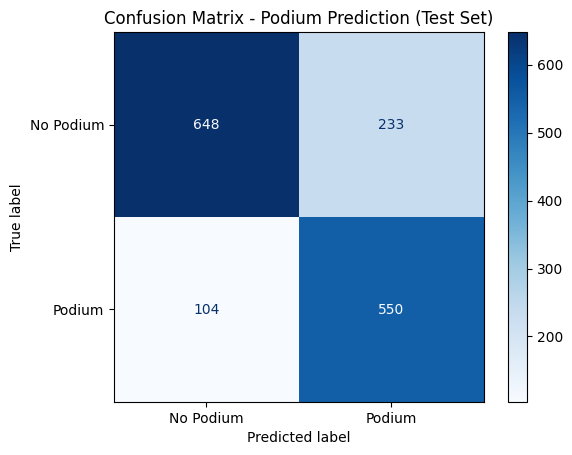

True Negatives (Correct No Podium): 648
False Positives (Wrongly Predicted Podium): 233
False Negatives (Missed Actual Podium): 104
True Positives (Correct Podium): 550

--- Regression Residual Analysis (Finishing Position) ---

Top 20 Largest Prediction Errors (Finishing Position with Context):
      actual_position  predicted_position  abs_residual  raceId  year        driverRef constructorName                     circuitName  grid
750                19            4.002039     14.997961    1063  2021            perez        Red Bull    Circuit de Spa-Francorchamps   7.0
993                13            4.617403      8.382597     320  1991         alboreto        Footwork         Adelaide Street Circuit   0.0
204                11            2.761875      8.238125     960  2016   max_verstappen        Red Bull    Circuit de Spa-Francorchamps   2.0
846                17            9.124195      7.875805    1126  2024           stroll    Aston Martin   Miami International Autodrome  11.

In [58]:
# --- STAGE 6: Error Analysis (Tuned XGBoost Model with Context) ---

import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt # For plotting confusion matrix

# Make sure necessary variables/objects from Block 5 are available:
# final_pipeline_regr, final_pipeline_clas (fitted pipelines)
# X_test, y_test_regr, y_test_clas
# y_pred_regr_final, y_pred_clas_final
# df_featured (from Block 2, needed to merge back context for residuals)
# Also assumes 'drivers', 'constructors', 'circuits' DataFrames are available from Block 1

print("--- STAGE 6 START: Error Analysis ---")

# --- 6a. Feature Importances (XGBoost) ---
print("\n--- Calculating Feature Importances (Tuned XGBoost) ---")

# For Classification Model
try:
    xgb_classifier_model = final_pipeline_clas.named_steps['classifier']
    preprocessor_clas = final_pipeline_clas.named_steps['preprocessor']
    # Handle potential issue if preprocessor wasn't fitted (should be in pipeline)
    if hasattr(preprocessor_clas, 'get_feature_names_out'):
        feature_names_out_clas = preprocessor_clas.get_feature_names_out()
        importances_clas = xgb_classifier_model.feature_importances_
        feature_importance_clas_df = pd.Series(importances_clas, index=feature_names_out_clas).sort_values(ascending=False)
        print("\n--- Feature Importances (Classification - Top 20) ---")
        print(feature_importance_clas_df.head(20))
    else:
        print("Could not get feature names from preprocessor for classification.")
except Exception as e:
    print(f"Could not get classification feature importances: {e}")

# For Regression Model
try:
    xgb_regressor_model = final_pipeline_regr.named_steps['regressor']
    preprocessor_regr = final_pipeline_regr.named_steps['preprocessor']
    if hasattr(preprocessor_regr, 'get_feature_names_out'):
        feature_names_out_regr = preprocessor_regr.get_feature_names_out()
        importances_regr = xgb_regressor_model.feature_importances_
        feature_importance_regr_df = pd.Series(importances_regr, index=feature_names_out_regr).sort_values(ascending=False)
        print("\n--- Feature Importances (Regression - Top 20) ---")
        print(feature_importance_regr_df.head(20))
    else:
         print("Could not get feature names from preprocessor for regression.")
except Exception as e:
    print(f"Could not get regression feature importances: {e}")


# --- 6b. Classification Confusion Matrix ---
print("\n--- Classification Confusion Matrix (Podium Finish) ---")
try:
    cm = confusion_matrix(y_test_clas, y_pred_clas_final)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Podium', 'Podium'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Podium Prediction (Test Set)")
    plt.show() # Display the plot

    tn, fp, fn, tp = cm.ravel()
    print(f"True Negatives (Correct No Podium): {tn}")
    print(f"False Positives (Wrongly Predicted Podium): {fp}")
    print(f"False Negatives (Missed Actual Podium): {fn}")
    print(f"True Positives (Correct Podium): {tp}")
except Exception as e:
    print(f"Could not generate confusion matrix: {e}")


# --- 6c. Regression Residual Analysis (with Context) ---
print("\n--- Regression Residual Analysis (Finishing Position) ---")
try:
    residuals = y_test_regr - y_pred_regr_final
    residual_analysis_df = pd.DataFrame({
        'actual_position': y_test_regr,
        'predicted_position': y_pred_regr_final,
        'residual': residuals,
        'abs_residual': np.abs(residuals)
    })

    # --- Start Enhancement: Merge Context ---
    # Merge basic context from df_featured using the index of X_test
    if 'df_featured' in locals() and df_featured is not None:
        context_cols = ['raceId', 'driverId', 'constructorId', 'circuitId', 'year', 'grid']
        context_cols = [col for col in context_cols if col in df_featured.columns] # Ensure columns exist
        residual_analysis_df = residual_analysis_df.merge(
            df_featured.loc[X_test.index, context_cols], # Use X_test.index to align
            left_index=True,
            right_index=True,
            how='left'
        )

        # Merge Driver Name (use driverRef)
        if 'drivers' in locals() and drivers is not None:
            residual_analysis_df = pd.merge(residual_analysis_df, drivers[['driverId', 'driverRef']], on='driverId', how='left')
        else: print("Warning: 'drivers' df not found for context merge.")

        # Merge Constructor Name
        if 'constructors' in locals() and constructors is not None:
            constructors_context = constructors[['constructorId', 'name']].rename(columns={'name': 'constructorName'})
            residual_analysis_df = pd.merge(residual_analysis_df, constructors_context, on='constructorId', how='left')
        else: print("Warning: 'constructors' df not found for context merge.")

        # Merge Circuit Name
        if 'circuits' in locals() and circuits is not None:
            circuits_context = circuits[['circuitId', 'name']].rename(columns={'name': 'circuitName'})
            residual_analysis_df = pd.merge(residual_analysis_df, circuits_context, on='circuitId', how='left')
        else: print("Warning: 'circuits' df not found for context merge.")

    else:
        print("Warning: df_featured not available. Cannot merge context for residual analysis.")
    # --- End Enhancement ---


    # Sort by largest absolute errors
    residual_analysis_df = residual_analysis_df.sort_values(by='abs_residual', ascending=False)

    print("\nTop 20 Largest Prediction Errors (Finishing Position with Context):")
    # Define columns to display - adjust as needed
    display_cols = ['actual_position', 'predicted_position', 'abs_residual', 'raceId', 'year', 'driverRef', 'constructorName', 'circuitName', 'grid']
    display_cols = [col for col in display_cols if col in residual_analysis_df.columns] # Show only available columns
    print(residual_analysis_df[display_cols].head(20).to_string()) # Use to_string to prevent truncation

    # --- Optional: Plot residuals ---
    # (Keep commented out unless needed)

except Exception as e:
    print(f"Could not perform residual analysis: {e}")


print("--- STAGE 6 COMPLETE ---")